# This is a the All Sky Simulation for MWM RV Targets

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table,vstack
from targetlib import testfield_gal,testfield_fk5,testfield_ecl
from astropy.coordinates import SkyCoord
from astropy.coordinates import Galactic,FK5,BarycentricTrueEcliptic
from astropy import units as u
%matplotlib inline

In [2]:
#Define some helper functions
def safe_replace(array, old_value, new_value, tolerance =.01):
    '''
    Replace all occurances of one float value with another
    
    Arguments:
        array: numerical numpy array with NaNs
        old_value: value to replace
        new_value: new value to put into array
    Optional:
        tolerance: What range to use in the float compare
    Returns:
        Array with corrected values
    '''   
    mask1 = np.zeros(array.shape, dtype=bool)
    np.less(array, old_value + tolerance, out=mask1, where=~np.isnan(array)) #Used to avoid warning with nan values
    mask2 = np.zeros(array.shape, dtype=bool)
    np.greater(array, old_value - tolerance, out=mask2, where=~np.isnan(array)) #Used to avoid warning with nan values
    
    array[(mask1 & mask2)] = new_value
    return(array)

## Read in Target Table
These targets include 60K BD desert targets plus RGB Stars from PEP.

In [3]:
rv_tab = Table.read('workspace/target_files/RV/MWM-RV-TargList-v04nv5.fits')
rv_tab

RA,DEC,CADENCE,TYPE,PRIORITY,VALUE,STARTYPE,H,TEFF,LOGG,FEH
float64,float64,bytes6,bytes2,int16,float32,bytes3,float32,float32,float32,float32
0.033324,79.662292,rv15x4,rv,45,1.0,MS,11.983,4623.007,4.4396977,-0.11634374
0.068263,79.412231,rv15x1,rv,45,1.0,MS,8.823,4747.19,4.605043,-0.20847328
0.084866,61.894894,rv15x4,rv,45,1.0,RC,12.178,4535.0405,1.9549698,-0.2726932
0.088255,61.611687,rv15x1,rv,45,1.0,RG,10.18,4218.296,1.4516535,-0.20068574
0.097458,61.695633,rv15x4,rv,45,1.0,RG,11.885,5001.123,2.4701812,-0.08274466
0.099521,61.863117,rv15x4,rv,45,1.0,RG,12.115,4789.2314,3.0111988,0.19969192
0.181357,0.49446,rv15x4,rv,45,1.0,RG,11.852,4898.8604,2.58268,-0.3042236
0.183633,61.865822,rv15x1,rv,45,1.0,RG,9.941,4187.848,1.3570518,-0.103872865
0.1982,0.515633,rv15x4,rv,45,1.0,MS,11.482,4999.9756,4.513607,0.42696965


## Statistical Binary Sample
This is a mock sample of ~100k stars (current pass has 60k) that overlaps with BHM_AQMES_WIDE

In [4]:
rv_few_tab = Table.read('workspace/target_files/RV/MWM-RV-fewEpoch-v01.fits')
rv_few_tab

RA,DEC,HMAG,CADENCE,TYPE,PRIORITY,VALUE
float32,float32,float32,bytes10,bytes5,int16,int16
179.87059,0.007181,10.806,mwm_rv_3x1,RVfew,59,1
179.71078,0.060904,10.087,mwm_rv_3x1,RVfew,59,1
179.79987,0.006546,10.684,mwm_rv_3x1,RVfew,59,1
179.74146,0.069818,10.756,mwm_rv_3x1,RVfew,59,1
179.889,0.164458,8.579,mwm_rv_3x1,RVfew,59,1
179.83592,0.08747,9.745,mwm_rv_3x1,RVfew,59,1
179.96346,0.623571,11.201,mwm_rv_3x1,RVfew,59,1
179.97356,0.539805,8.574,mwm_rv_3x1,RVfew,59,1
179.80653,0.379836,11.374,mwm_rv_3x1,RVfew,59,1


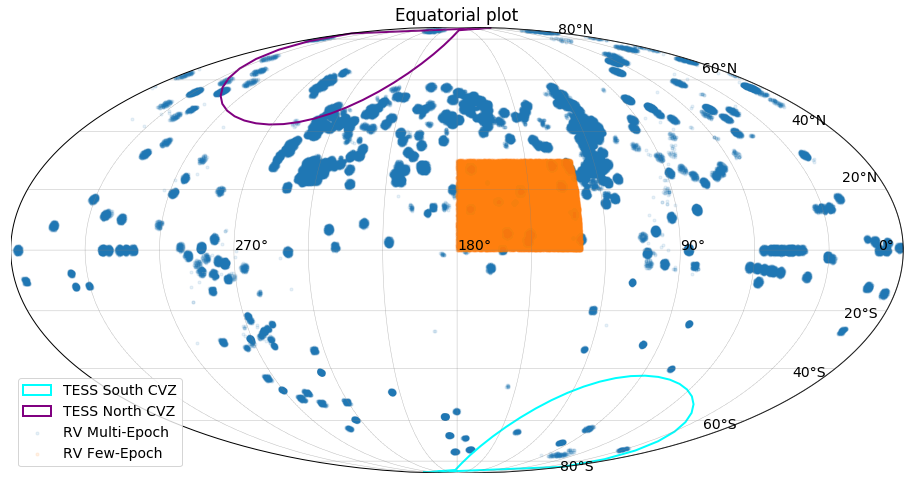

In [5]:
plt.rcParams.update({'font.size': 14})
(fig,bmap) = testfield_fk5()
#Plot RV Many-Epoch Targets
rvx,rvy = bmap(rv_tab['RA'],rv_tab['DEC'])
bmap.scatter(rvx,rvy,marker='.',label='RV Multi-Epoch',alpha=0.1)
#Plot RV Few-Epoch Targets
rvfewx,rvfewy = bmap(rv_few_tab['RA'],rv_few_tab['DEC'])
bmap.scatter(rvfewx,rvfewy,marker='.',label='RV Few-Epoch',alpha=0.1)
plt.title("Equatorial plot")
plt.legend()
plt.savefig("RV.jpg")
plt.show()

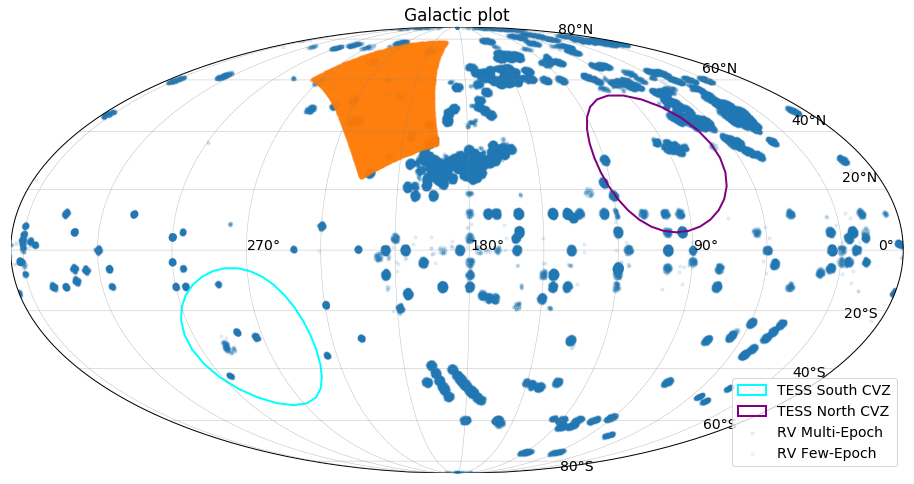

In [6]:
plt.rcParams.update({'font.size': 14})
(fig,bmap) = testfield_gal()
#Plot RV Many-Epoch Targets
rv_coord = SkyCoord(rv_tab['RA'], rv_tab['DEC'],unit=(u.deg,u.deg))
rv_coord_gal = rv_coord.transform_to(Galactic())
rvx,rvy = bmap(rv_coord_gal.l,rv_coord_gal.b)
bmap.scatter(rvx,rvy,marker='.',label='RV Multi-Epoch',alpha=0.1)
#Plot RV Few-Epoch Targets
rvfew_coord = SkyCoord(rv_few_tab['RA'], rv_few_tab['DEC'],unit=(u.deg,u.deg))
rvfew_coord_gal = rvfew_coord.transform_to(Galactic())
rvfewx,rvfewy = bmap(rvfew_coord_gal.l,rvfew_coord_gal.b)
bmap.scatter(rvfewx,rvfewy,marker='.',label='RV Few-Epoch',alpha=0.1)
plt.title("Galactic plot")
plt.legend()
plt.savefig("RVgal.jpg")
plt.show()

## Create Target Table

In [7]:
target_tab = Table()

In [8]:
target_tab['ra'] = np.concatenate([rv_tab['RA'],rv_few_tab['RA']])
target_tab['dec'] = np.concatenate([rv_tab['DEC'],rv_few_tab['DEC']])

## Fix Cadence Names

In [9]:
cadence_list = list(rv_tab['CADENCE'])
cadence_list = ['mwm_'+ x.strip() for x in cadence_list]
cadence_list = [x.replace('rv','rv_') for x in cadence_list]
cadence_arr = np.concatenate([np.array(cadence_list),rv_few_tab['CADENCE']])
cadence_arr

array(['mwm_rv_15x4', 'mwm_rv_15x1', 'mwm_rv_15x4', ..., 'mwm_rv_3x1',
       'mwm_rv_3x1', 'mwm_rv_3x1'], dtype='<U11')

In [10]:
target_tab['cadence'] = cadence_arr
target_tab['type'] = np.concatenate([np.repeat('RVmany',len(rv_tab))
                                     ,np.repeat('RVfew',len(rv_few_tab))])

target_tab['priority'] = np.concatenate([np.repeat(np.array(51,dtype='int32'),len(rv_tab)),
                                        np.repeat(np.array(59,dtype='int32'),len(rv_few_tab))])
target_tab['value'] = np.repeat(np.array(1.0,dtype='float32'),len(target_tab))
target_tab

ra,dec,cadence,type,priority,value
float64,float64,str11,str6,int32,float32
0.033324,79.662292,mwm_rv_15x4,RVmany,51,1.0
0.068263,79.412231,mwm_rv_15x1,RVmany,51,1.0
0.084866,61.894894,mwm_rv_15x4,RVmany,51,1.0
0.088255,61.611687,mwm_rv_15x1,RVmany,51,1.0
0.097458,61.695633,mwm_rv_15x4,RVmany,51,1.0
0.099521,61.863117,mwm_rv_15x4,RVmany,51,1.0
0.181357,0.49446,mwm_rv_15x4,RVmany,51,1.0
0.183633,61.865822,mwm_rv_15x1,RVmany,51,1.0
0.1982,0.515633,mwm_rv_15x4,RVmany,51,1.0


In [11]:
target_tab.write('mwm_rv_target_v01.fits',overwrite=True)

## Create Cadence Table

In [12]:
rv_cad_tab = Table.read('workspace/target_files/RV/MWM-RVcadences_v2_ideal.fits')
rv_cad_tab

cadence,nepochs,delta [72],softness [72],delta_min [72],delta_max [72],lunation [72],instrument [72]
bytes6,int32,float32,float32,float32,float32,float32,bytes6
rv3x1,3,0.0 .. nan,1.0 .. nan,180.0 .. nan,420.0 .. nan,1.0 .. nan,apogee ..
rv3x2,6,0.0 .. nan,1.0 .. nan,180.0 .. nan,420.0 .. nan,1.0 .. nan,apogee ..
rv3x4,12,0.0 .. nan,1.0 .. nan,180.0 .. nan,420.0 .. nan,1.0 .. nan,apogee ..
rv6x1,6,0.0 .. nan,1.0 .. nan,180.0 .. nan,420.0 .. nan,1.0 .. nan,apogee ..
rv6x2,12,0.0 .. nan,1.0 .. nan,180.0 .. nan,420.0 .. nan,1.0 .. nan,apogee ..
rv6x4,24,0.0 .. nan,1.0 .. nan,180.0 .. nan,420.0 .. nan,1.0 .. nan,apogee ..
rv9x1,9,0.0 .. nan,1.0 .. nan,180.0 .. nan,420.0 .. nan,1.0 .. nan,apogee ..
rv9x2,18,0.0 .. nan,1.0 .. nan,180.0 .. nan,420.0 .. nan,1.0 .. nan,apogee ..
rv9x4,36,0.0 .. nan,1.0 .. nan,180.0 .. nan,420.0 .. nan,1.0 .. nan,apogee ..


## Reading in BHM cadence table
For the statistical sample, we will just use the AQMES_WIDE cadence and turn it into our mwm_rv_3x1

In [13]:
bhm_cad_tab = Table.read('workspace/target_files/RV/SDSS-V_bhm_cadence_description_v3.fits')
bhm_cad_tab

cadence,nepochs,delta [1392],softness [1392],delta_min [1392],delta_max [1392]
bytes21,int32,float32,float32,float32,float32
bhm_spiders_1x1,1,0.0 .. nan,0.0 .. nan,0.0 .. nan,0.0 .. nan
bhm_spiders_1x2,2,0.0 .. nan,0.0 .. nan,0.0 .. nan,0.0 .. nan
bhm_spiders_1x3,3,0.0 .. nan,0.0 .. nan,0.0 .. nan,0.0 .. nan
bhm_spiders_1x4,4,0.0 .. nan,0.0 .. nan,0.0 .. nan,0.0 .. nan
bhm_spiders_1x8,8,0.0 .. nan,0.0 .. nan,0.0 .. nan,0.0 .. nan
bhm_aqmes_wide_2x4,8,0.0 .. nan,0.0 .. nan,0.0 .. nan,0.0 .. nan
bhm_aqmes_wide_3x4,12,0.0 .. nan,0.0 .. nan,0.0 .. nan,0.0 .. nan
bhm_aqmes_medium_12x4,48,0.0 .. nan,0.0 .. nan,0.0 .. nan,0.0 .. nan
bhm_rm_174x8,1392,0.0 .. 0.0,0.0 .. 2.0,0.0 .. 0.0,0.0 .. 2.0


In [14]:
print(bhm_cad_tab['cadence'][6])
print((bhm_cad_tab['delta'][6])[0:12])
print((bhm_cad_tab['delta_min'][6])[0:12])
print((bhm_cad_tab['delta_max'][6])[0:12])

mwm_rv_31_delta = np.array([0., 730.5, 730.5])
mwm_rv_31_delta_min = np.array([0., 608.75, 608.75])
mwm_rv_31_delta_max = np.array([0., 852.25, 852.25])

bhm_aqmes_wide_3x4
[  0.    0.    0.    0.  730.5   0.    0.    0.  730.5   0.    0.    0. ]
[  0.     0.     0.     0.   608.75   0.     0.     0.   608.75   0.
   0.     0.  ]
[  0.    15.    15.    15.   852.25  15.    15.    15.   852.25  15.
  15.    15.  ]


## Clean up the cadence names

In [15]:
cadence_tab = Table()

In [16]:
cadence_list = list(rv_cad_tab['cadence'])
cadence_list = ['mwm_'+ x for x in cadence_list]
cadence_list = [x.replace('rv','rv_') for x in cadence_list]
print(cadence_list)

['mwm_rv_3x1', 'mwm_rv_3x2', 'mwm_rv_3x4', 'mwm_rv_6x1', 'mwm_rv_6x2', 'mwm_rv_6x4', 'mwm_rv_9x1', 'mwm_rv_9x2', 'mwm_rv_9x4', 'mwm_rv_12x1', 'mwm_rv_12x2', 'mwm_rv_12x4', 'mwm_rv_15x1', 'mwm_rv_15x2', 'mwm_rv_15x4', 'mwm_rv_18x1', 'mwm_rv_18x2', 'mwm_rv_18x4']


In [17]:
cadence_tab['cadence'] = cadence_list
cadence_tab['nepochs'] = rv_cad_tab['nepochs']

## Let's insert the BHM delta

In [18]:
print(rv_cad_tab['delta'][0])
rv_cad_tab['delta'][0] = np.concatenate([mwm_rv_31_delta,np.repeat(np.nan,69)])
print(rv_cad_tab['delta'][0])

[ 0.  3.  3. nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
[  0.  730.5 730.5   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]


In [19]:
cadence_tab['delta'] = rv_cad_tab['delta']
cadence_tab

cadence,nepochs,delta [72]
str11,int32,float32
mwm_rv_3x1,3,0.0 .. nan
mwm_rv_3x2,6,0.0 .. nan
mwm_rv_3x4,12,0.0 .. nan
mwm_rv_6x1,6,0.0 .. nan
mwm_rv_6x2,12,0.0 .. nan
mwm_rv_6x4,24,0.0 .. nan
mwm_rv_9x1,9,0.0 .. nan
mwm_rv_9x2,18,0.0 .. nan
mwm_rv_9x4,36,0.0 .. nan


In [20]:
#Fix issue with first number
for i in range(len(rv_cad_tab)):
    rv_cad_tab['delta_min'][i][0] = 0
print(rv_cad_tab['delta'][12])
print(rv_cad_tab['delta_min'][17])

[  0.   3.   3.  30.   3.   3.  30.   3.   3. 300.   3.   3.  30.   3.
   3.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan]
[  0.   0.   0.   0.   1.   0.   0.   0.   1.   0.   0.   0.  18.   0.
   0.   0.   1.   0.   0.   0.   1.   0.   0.   0.  18.   0.   0.   0.
   1.   0.   0.   0.   1.   0.   0.   0. 180.   0.   0.   0.   1.   0.
   0.   0.   1.   0.   0.   0.  18.   0.   0.   0.   1.   0.   0.   0.
   1.   0.   0.   0.  18.   0.   0.   0.   1.   0.   0.   0.   1.   0.
   0.   0.]


In [21]:
#Drop the min down a little bit from 18 to 15 and 180 to 150
print(rv_cad_tab['delta_min'][17])
rv_cad_tab['delta_min'] = safe_replace(rv_cad_tab['delta_min'],18,15)
rv_cad_tab['delta_min'] = safe_replace(rv_cad_tab['delta_min'],180,150)
print(rv_cad_tab['delta_min'][17])

[  0.   0.   0.   0.   1.   0.   0.   0.   1.   0.   0.   0.  18.   0.
   0.   0.   1.   0.   0.   0.   1.   0.   0.   0.  18.   0.   0.   0.
   1.   0.   0.   0.   1.   0.   0.   0. 180.   0.   0.   0.   1.   0.
   0.   0.   1.   0.   0.   0.  18.   0.   0.   0.   1.   0.   0.   0.
   1.   0.   0.   0.  18.   0.   0.   0.   1.   0.   0.   0.   1.   0.
   0.   0.]
[  0.   0.   0.   0.   1.   0.   0.   0.   1.   0.   0.   0.  15.   0.
   0.   0.   1.   0.   0.   0.   1.   0.   0.   0.  15.   0.   0.   0.
   1.   0.   0.   0.   1.   0.   0.   0. 150.   0.   0.   0.   1.   0.
   0.   0.   1.   0.   0.   0.  15.   0.   0.   0.   1.   0.   0.   0.
   1.   0.   0.   0.  15.   0.   0.   0.   1.   0.   0.   0.   1.   0.
   0.   0.]


In [22]:
#Add in BHM minimums
print(rv_cad_tab['delta_min'][0])
rv_cad_tab['delta_min'][0] = np.concatenate([mwm_rv_31_delta_min,np.repeat(np.nan,69)])
print(rv_cad_tab['delta_min'][0])

[ 0.  1.  1. nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
[  0.   608.75 608.75    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan]


In [23]:
cadence_tab['delta_min'] = rv_cad_tab['delta_min']
cadence_tab

cadence,nepochs,delta [72],delta_min [72]
str11,int32,float32,float32
mwm_rv_3x1,3,0.0 .. nan,0.0 .. nan
mwm_rv_3x2,6,0.0 .. nan,0.0 .. nan
mwm_rv_3x4,12,0.0 .. nan,0.0 .. nan
mwm_rv_6x1,6,0.0 .. nan,0.0 .. nan
mwm_rv_6x2,12,0.0 .. nan,0.0 .. nan
mwm_rv_6x4,24,0.0 .. nan,0.0 .. nan
mwm_rv_9x1,9,0.0 .. nan,0.0 .. nan
mwm_rv_9x2,18,0.0 .. nan,0.0 .. nan
mwm_rv_9x4,36,0.0 .. nan,0.0 .. nan


## Make all delta_max = delta + 270

In [24]:
new_delta_max = cadence_tab['delta'] + 270
new_delta_max = safe_replace(new_delta_max,270,0)
rv_cad_tab['delta_max'] = new_delta_max
print(cadence_tab['delta'][17])
print(new_delta_max[17])

[  0.   0.   0.   0.   3.   0.   0.   0.   3.   0.   0.   0.  30.   0.
   0.   0.   3.   0.   0.   0.   3.   0.   0.   0.  30.   0.   0.   0.
   3.   0.   0.   0.   3.   0.   0.   0. 300.   0.   0.   0.   3.   0.
   0.   0.   3.   0.   0.   0.  30.   0.   0.   0.   3.   0.   0.   0.
   3.   0.   0.   0.  30.   0.   0.   0.   3.   0.   0.   0.   3.   0.
   0.   0.]
[  0.   0.   0.   0. 273.   0.   0.   0. 273.   0.   0.   0. 300.   0.
   0.   0. 273.   0.   0.   0. 273.   0.   0.   0. 300.   0.   0.   0.
 273.   0.   0.   0. 273.   0.   0.   0. 570.   0.   0.   0. 273.   0.
   0.   0. 273.   0.   0.   0. 300.   0.   0.   0. 273.   0.   0.   0.
 273.   0.   0.   0. 300.   0.   0.   0. 273.   0.   0.   0. 273.   0.
   0.   0.]


In [25]:
#Allow for some more wiggle room with weather on back to back exposures
new_delta_max = safe_replace(rv_cad_tab['delta_max'], 0, 0.04)
#Fix issue with first number
for i in range(len(new_delta_max)):
    new_delta_max[i][0] = 0
print(new_delta_max[16])
rv_cad_tab['delta_max'] = new_delta_max

[0.00e+00 4.00e-02 2.73e+02 4.00e-02 2.73e+02 4.00e-02 3.00e+02 4.00e-02
 2.73e+02 4.00e-02 2.73e+02 4.00e-02 3.00e+02 4.00e-02 2.73e+02 4.00e-02
 2.73e+02 4.00e-02 5.70e+02 4.00e-02 2.73e+02 4.00e-02 2.73e+02 4.00e-02
 3.00e+02 4.00e-02 2.73e+02 4.00e-02 2.73e+02 4.00e-02 3.00e+02 4.00e-02
 2.73e+02 4.00e-02 2.73e+02 4.00e-02      nan      nan      nan      nan
      nan      nan      nan      nan      nan      nan      nan      nan
      nan      nan      nan      nan      nan      nan      nan      nan
      nan      nan      nan      nan      nan      nan      nan      nan
      nan      nan      nan      nan      nan      nan      nan      nan]


In [26]:
#Add in BHM maximums
print(rv_cad_tab['delta_max'][0])
rv_cad_tab['delta_max'][0] = np.concatenate([mwm_rv_31_delta_max,np.repeat(np.nan,69)])
print(rv_cad_tab['delta_max'][0])

[   0.  1000.5 1000.5    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan]
[  0.   852.25 852.25    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    n

In [27]:
cadence_tab['delta_max'] = rv_cad_tab['delta_max']
cadence_tab

cadence,nepochs,delta [72],delta_min [72],delta_max [72]
str11,int32,float32,float32,float32
mwm_rv_3x1,3,0.0 .. nan,0.0 .. nan,0.0 .. nan
mwm_rv_3x2,6,0.0 .. nan,0.0 .. nan,0.0 .. nan
mwm_rv_3x4,12,0.0 .. nan,0.0 .. nan,0.0 .. nan
mwm_rv_6x1,6,0.0 .. nan,0.0 .. nan,0.0 .. nan
mwm_rv_6x2,12,0.0 .. nan,0.0 .. nan,0.0 .. nan
mwm_rv_6x4,24,0.0 .. nan,0.0 .. nan,0.0 .. nan
mwm_rv_9x1,9,0.0 .. nan,0.0 .. nan,0.0 .. nan
mwm_rv_9x2,18,0.0 .. nan,0.0 .. nan,0.0 .. nan
mwm_rv_9x4,36,0.0 .. nan,0.0 .. nan,0.0 .. nan


## Let's fix lunation

In [28]:
fix_lunation = rv_cad_tab['lunation']
safe_replace(fix_lunation, 100, 1, tolerance =.01)
cadence_tab['lunation'] = fix_lunation
print(cadence_tab[(cadence_tab['cadence'] == 'mwm_rv_18x4')]['lunation'].data)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [29]:
rv_cad_tab['instrument'][(rv_cad_tab['instrument'] == b'')] = np.nan
print(rv_cad_tab['instrument'][16])

[b'apogee' b'apogee' b'apogee' b'apogee' b'apogee' b'apogee' b'apogee'
 b'apogee' b'apogee' b'apogee' b'apogee' b'apogee' b'apogee' b'apogee'
 b'apogee' b'apogee' b'apogee' b'apogee' b'apogee' b'apogee' b'apogee'
 b'apogee' b'apogee' b'apogee' b'apogee' b'apogee' b'apogee' b'apogee'
 b'apogee' b'apogee' b'apogee' b'apogee' b'apogee' b'apogee' b'apogee'
 b'apogee' b'nan' b'nan' b'nan' b'nan' b'nan' b'nan' b'nan' b'nan' b'nan'
 b'nan' b'nan' b'nan' b'nan' b'nan' b'nan' b'nan' b'nan' b'nan' b'nan'
 b'nan' b'nan' b'nan' b'nan' b'nan' b'nan' b'nan' b'nan' b'nan' b'nan'
 b'nan' b'nan' b'nan' b'nan' b'nan' b'nan' b'nan']


In [30]:
cadence_tab['instrument'] = rv_cad_tab['instrument']

In [31]:
cadence_tab

cadence,nepochs,delta [72],delta_min [72],delta_max [72],lunation [72],instrument [72]
str11,int32,float32,float32,float32,float32,bytes6
mwm_rv_3x1,3,0.0 .. nan,0.0 .. nan,0.0 .. nan,1.0 .. nan,apogee .. nan
mwm_rv_3x2,6,0.0 .. nan,0.0 .. nan,0.0 .. nan,1.0 .. nan,apogee .. nan
mwm_rv_3x4,12,0.0 .. nan,0.0 .. nan,0.0 .. nan,1.0 .. nan,apogee .. nan
mwm_rv_6x1,6,0.0 .. nan,0.0 .. nan,0.0 .. nan,1.0 .. nan,apogee .. nan
mwm_rv_6x2,12,0.0 .. nan,0.0 .. nan,0.0 .. nan,1.0 .. nan,apogee .. nan
mwm_rv_6x4,24,0.0 .. nan,0.0 .. nan,0.0 .. nan,1.0 .. nan,apogee .. nan
mwm_rv_9x1,9,0.0 .. nan,0.0 .. nan,0.0 .. nan,1.0 .. nan,apogee .. nan
mwm_rv_9x2,18,0.0 .. nan,0.0 .. nan,0.0 .. nan,1.0 .. nan,apogee .. nan
mwm_rv_9x4,36,0.0 .. nan,0.0 .. nan,0.0 .. nan,1.0 .. nan,apogee .. nan


In [32]:
cadence_tab.write('mwm_rv_cadence_v01.fits',overwrite=True)

In [33]:
test_tab = Table.read('mwm_rv_cadence_v01.fits')

In [34]:
for cadence in test_tab:
    print("Delta: ",cadence['cadence'],["{:0.2f}".format(float(x)) for x in cadence['delta']])
    print("Delta_Max: ",cadence['cadence'],["{:0.2f}".format(float(x)) for x in cadence['delta_max']])
    print("Delta_Min: ",cadence['cadence'],["{:0.2f}".format(float(x)) for x in cadence['delta_min']])

Delta:  mwm_rv_3x1 ['0.00', '730.50', '730.50', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
Delta_Max:  mwm_rv_3x1 ['0.00', '852.25', '852.25', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan

In [35]:
print(test_tab['lunation'][16])

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
